In [78]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import re
from D_Age_Technologies import *

sns.set_style('darkgrid')
sns.set_palette('viridis')

DATA_PATH_2020 = './data/2020.csv'
DATA_PATH_2019 = './data/2019.csv'
DATA_PATH_2018 = './data/2018.csv'

df_2018 = pd.read_csv(DATA_PATH_2018)
df_2019 = pd.read_csv(DATA_PATH_2019)
df_2020 = pd.read_csv(DATA_PATH_2020)

technology = 'Your main technology / programming language'
age = 'Age'
age_segment = 'age_segment'

In [79]:
def merge(data_frames, common_columns=[]):
    return pd.concat(data_frames, ignore_index=True)[common_columns]

In [80]:
# Merge the 2019 and 2020 datasets on common columns
merged_df = merge(data_frames=[df_2019, df_2020], common_columns=[age, technology])
print('Total number of rows', merged_df.shape[0])
assert merged_df.shape[0] == df_2019.shape[0] + df_2020.shape[0]

Total number of rows 2244


## Univariate Analysis: Age

In [81]:
# Explore the portion of missing data in age column
print('Number of Age missing rows', sum(merged_df[age].isna()))
print('Percentage of Age missing', 100*sum(merged_df[age].isna())/merged_df[age].shape[0], '%')

Number of Age missing rows 136
Percentage of Age missing 6.0606060606060606 %


In [82]:
# Explore the mean, min, max, quartiles of the age column
statistics_df = merged_df.loc[:, [age]].describe()
mode_df = merged_df.loc[:, [age]].mode().rename(index={0: 'mode'})
statistics_df = pd.concat([statistics_df, mode_df]).transpose()
print("Central Tendancy and Spread of Age:")
statistics_df

Central Tendancy and Spread of Age:


,count,mean,std,min,25%,50%,75%,max,mode
Age,2108.0,32.470588,5.498379,20.0,29.0,32.0,35.0,69.0,30.0


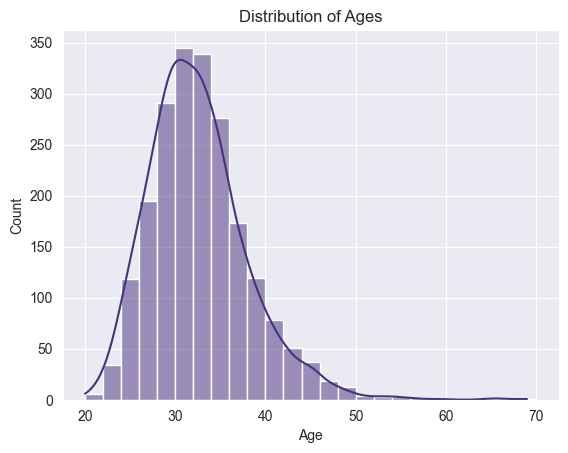

In [83]:
# Distribution of age for employees who worked in IT and submitted the form
sns.histplot(data=merged_df[age], kde=True, binwidth=2)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')
plt.show()

### Imputing missing Age values

- Impute the missing values with mode. Because it's significantly repeated 500 times, 25% of form responders are in their 30s. 
- Although the mode is very close to the mean, it's chosen for imputation. This is because the mean is slightly right shifted by the very few old ages(outliers), however, the mode is not affected by them.

In [84]:
age_mode=mode_df.loc['mode', age]
merged_df[age] = merged_df[age].fillna(age_mode)
assert sum(merged_df[age].isna()) == 0

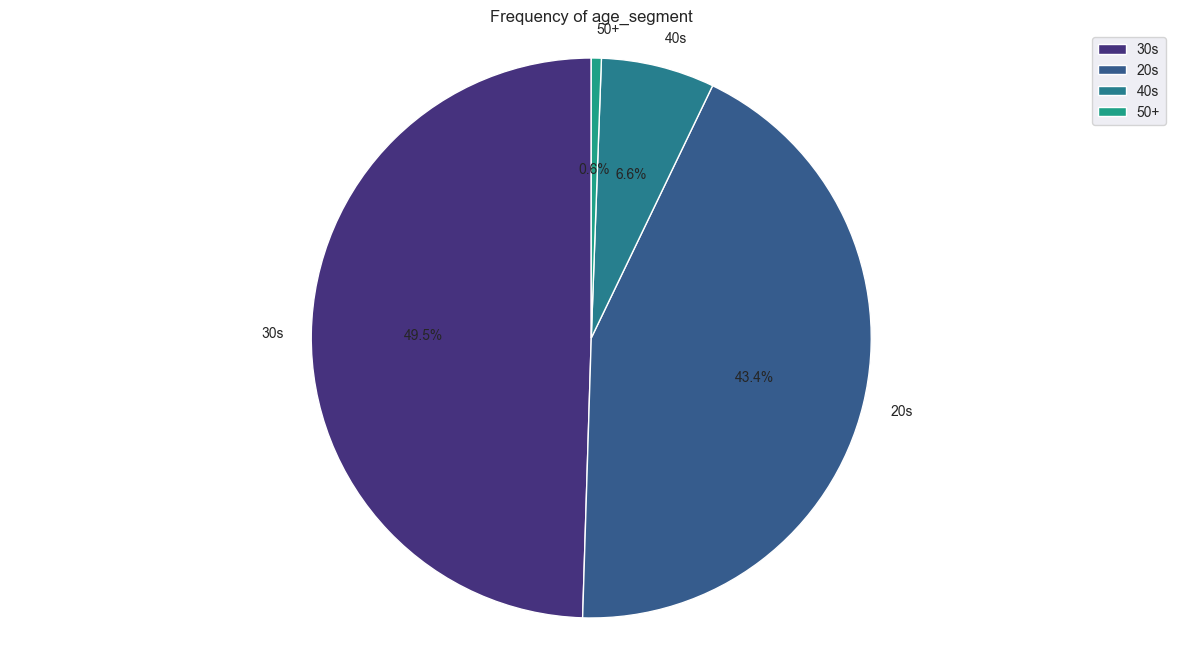

In [85]:
plot_pie_chart(segment_age(merged_df, 
                        age_segments=['20s', '30s', '40s', '50+'],
                        age_ranges=[20, 30, 40, 50, 120]), age_segment)

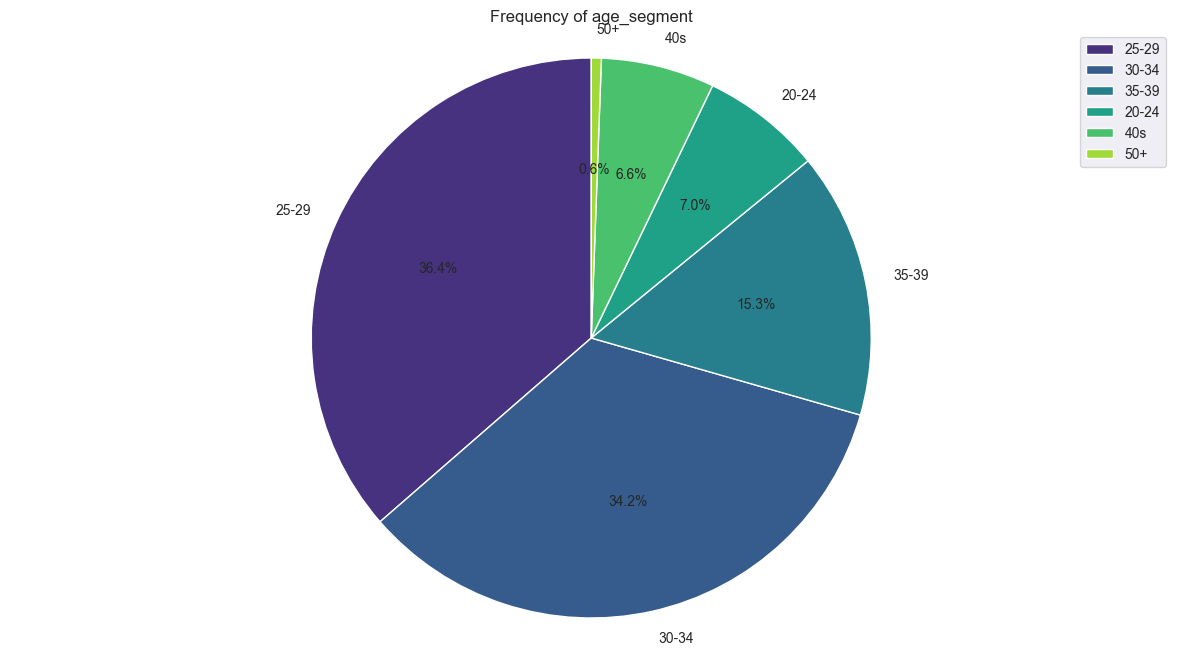

In [86]:
merged_df = segment_age(merged_df, 
                        age_segments=['20-24', '25-29', '30-34', '35-39', '40s', '50+'], 
                        age_ranges=[20, 25, 30, 35, 40, 50, 120])
plot_pie_chart(merged_df, age_segment)

|Expectation|Collected|Match?|
|:----|:----|:----|
|The question is feasible to answer and the data exhibits a balanced distribution across the age groups of 20s, 30s, and 40s. Therefore, we can analyze and provide insights for each age group individually.|92.8% of the responders are within their 20s and 30s and only 6.6% are at their 40s. | The 40s age segment is not represented suffieciently. It seems that people at their 40s don't engage much in such surveys. To address this issue and ensure more reliable analysis, we will divide the survey responders into more specific age segments by grouping them into intervals of five years each. This will allow us to have more groups to study the question on. ❌|
|People above 50 years are more likely to be retired.| There exist very few that has |✔|
|There’s should be no teen-ager or child because this is an IT salary, and people below 20 very few of them are hired in the IT industry.|Youngest age was 20, no year below.|✔|

## Univariate Analysis: Langauages and Technologies

In [87]:
# Explore the portion of missing data in age column
print('Number of technology missing rows', sum(merged_df[technology].isna()))
print('Percentage of technology missing', 100*sum(merged_df[technology].isna())/merged_df[technology].shape[0])

Number of technology missing rows 141
Percentage of technology missing 6.283422459893048


In [88]:
# Statistics about the technology
unique_technologies = merged_df[technology].unique()
print("Number of unique langauages: ", len(unique_technologies))
print("Most repeated technology among IT Employees: ", merged_df.loc[:, [technology]].mode().iloc[0,0])

Number of unique langauages:  275
Most repeated technology among IT Employees:  Python


By investigating the data, values are comma-separated words. Hence, we'll no longer use the python built-in unique(), instead, we will implement our getUnique.

In [89]:
none_values = [None, 'nan', 'nothing', 'not relevant', 'none', '']

def clean_languages(df):
    for indx, row in df.iterrows():
        if row[technology] is not None and type(row[technology]) is not float:
            # split string using , / &
            values = re.split("[,&/]", row[technology])
            for value in values:
                # remove leading and trailing spaces
                # change to lower case
                processed_value = value.strip().lower().replace(".", "")
                if ("go" in processed_value):
                    processed_value = 'go'
                elif(processed_value == "js"):
                    processed_value = 'javascript'
                elif ("cloud" in processed_value or "devops" in processed_value):
                    processed_value = 'cloud'
                elif (processed_value in none_values):
                    processed_value = None

                df.loc[indx, technology] = processed_value
    return df

In [90]:
cleaned_df = clean_languages(merged_df)
unique_technologies = cleaned_df[technology].unique()
print("After data cleaning and inforcing consistency\nNumber of unique langauges: ", len(unique_technologies))

After data cleaning and inforcing consistency
Number of unique langauges:  143


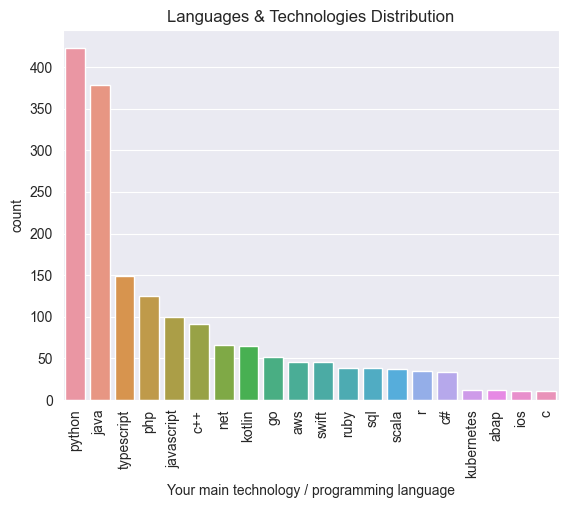

In [92]:
# Distribution of Technologies for employees who worked in IT and submitted the form
tech_counts = cleaned_df[technology].value_counts()

# Filter out technologies that appear less than 10 times
tech_counts = tech_counts[tech_counts >= 10]

# filter dataframe to only include rows with technologies that appear 10 times or more
cleaned_df = cleaned_df[cleaned_df[technology].isin(tech_counts.index)]
sns.countplot(data=cleaned_df, x=technology, order=tech_counts.index)
plt.xticks(rotation=90)
plt.title('Languages & Technologies Distribution')
plt.show()

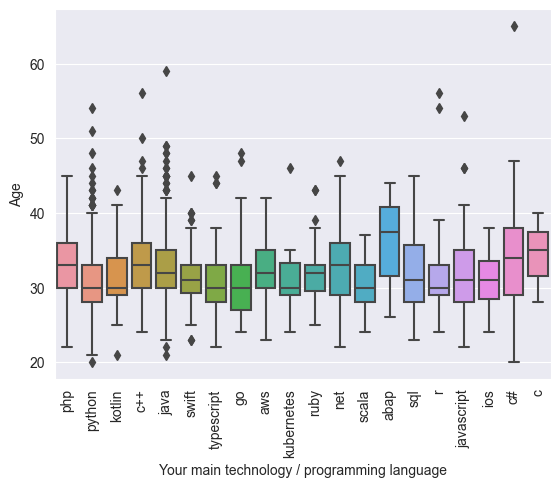

In [93]:
sns.boxplot(x=technology, y=age, data=cleaned_df)
plt.xticks(rotation=90)
plt.show()

- The median of most technologies lies around the 30s, this is obvious since employees at their 30s are represented with high frequency
- It's shown that the 3rd quartile for go, c# reaches people above their 45s which makes since, such langauages has exicted since a while
- Then goes java, c, c++ and php, net and sql

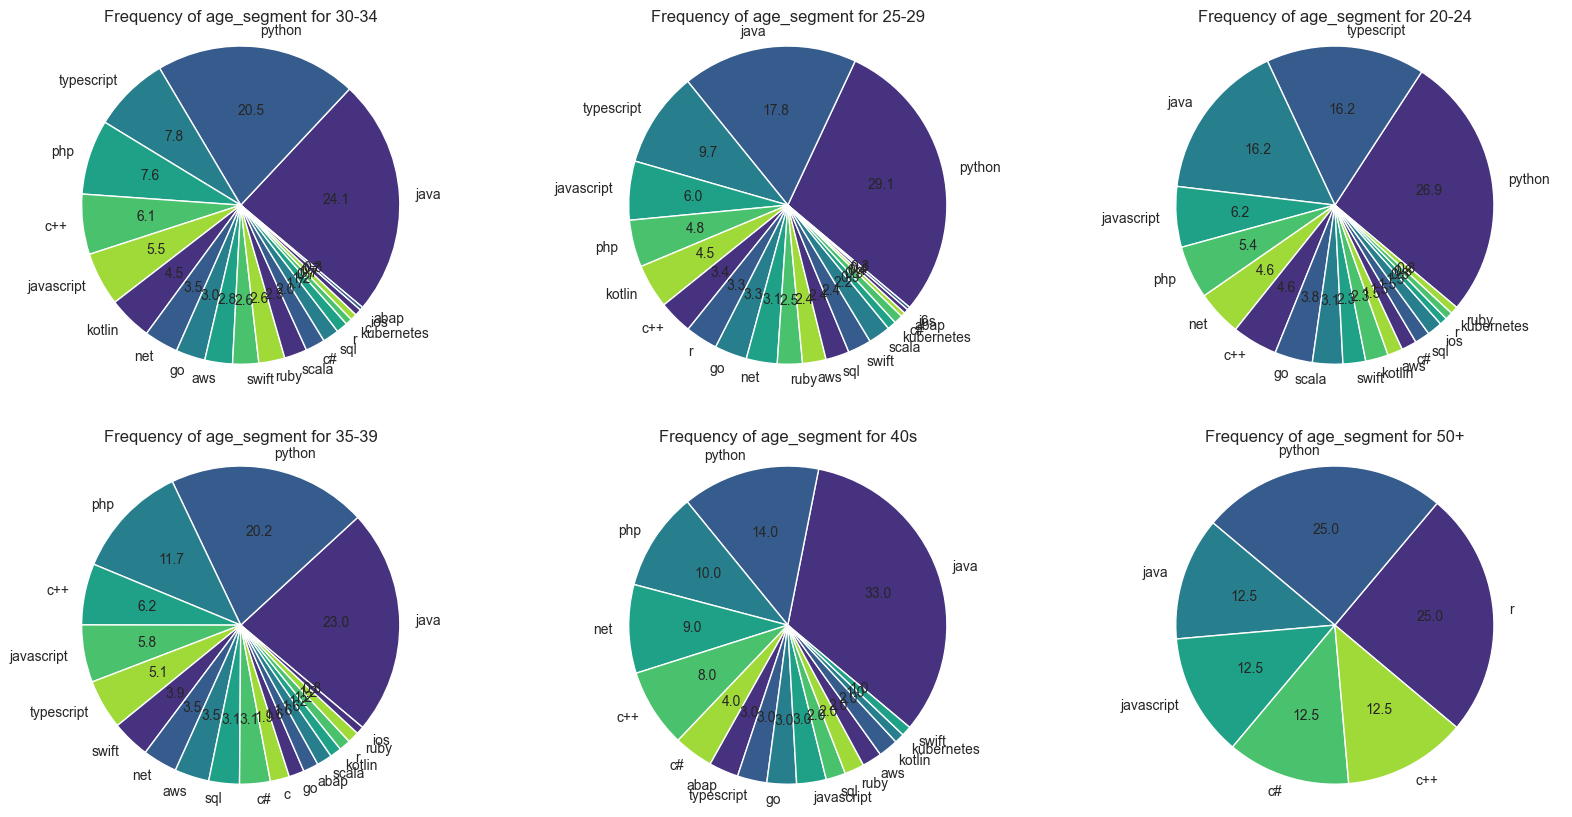

In [127]:
def plot_pie_charts(df, analysis_column, division_column):

    plt.figure(figsize=(20, 10))
    analysis_categories = df[analysis_column].dropna().unique()
    for indx, category in enumerate(analysis_categories):
        plt.subplot(2, len(analysis_categories)//2, indx+1)
        category_mask = df[analysis_column] == category
        value_counts = df[category_mask][division_column].value_counts()
        labels = value_counts.index.tolist()
        sizes = value_counts.values.tolist()

        # Plotting the pie chart
        plt.pie(sizes, labels=labels, autopct='%1.1f', startangle=-40, radius=5)
        plt.yticks(rotation=90)
        plt.axis('equal') 
        plt.title(f'Frequency of {analysis_column} for {category}')
    plt.show()

plot_pie_charts(cleaned_df, analysis_column='age_segment', division_column=technology)